# I Start with USPTO patent reassignment data. I identify patent portfolio transfers by detecting clustered patent ownership changes between the same firms within short time windows.

In [181]:
import pandas as pd 
from tqdm.auto import tqdm
import requests
from pathlib import Path
import os, time, json, re, requests

base = "/Users/alimacmini/Ali/csv/"

files = {
    "assignment": "assignment.csv",
    "assignee": "assignee.csv",
    "assignor": "assignor.csv",
    "conveyance": "assignment_conveyance.csv"
}

dfs = {}
for k, v in files.items():
    df = pd.read_csv(base + v, nrows=5)
    dfs[k] = df
    print(f"\n=== {k.upper()} ===")
    print(df.columns.tolist())



=== ASSIGNMENT ===
['rf_id', 'file_id', 'cname', 'caddress_1', 'caddress_2', 'caddress_3', 'caddress_4', 'reel_no', 'frame_no', 'convey_text', 'record_dt', 'last_update_dt', 'page_count', 'purge_in']

=== ASSIGNEE ===
['rf_id', 'ee_name', 'ee_address_1', 'ee_address_2', 'ee_city', 'ee_state', 'ee_postcode', 'ee_country']

=== ASSIGNOR ===
['rf_id', 'or_name', 'exec_dt', 'ack_dt']

=== CONVEYANCE ===
['rf_id', 'convey_ty', 'employer_assign']


In [182]:
base = "/Users/alimacmini/Ali/csv/"

assignment = pd.read_csv(base + "assignment.csv", usecols=[
    "rf_id", "record_dt", "convey_text"
])

assignor = pd.read_csv(base + "assignor.csv", usecols=[
    "rf_id", "or_name", "exec_dt"
])

assignee = pd.read_csv(base + "assignee.csv", usecols=[
    "rf_id", "ee_name"
])

conveyance = pd.read_csv(base + "assignment_conveyance.csv", usecols=[
    "rf_id", "convey_ty"
])

# merge step by step (inner joins only)
df = assignment.merge(assignor, on="rf_id", how="inner")
df = df.merge(assignee, on="rf_id", how="inner")
df = df.merge(conveyance, on="rf_id", how="inner")

print(df.head())
print("\nRows:", len(df))


      rf_id                                                    convey_text  \
0  12800340   ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).   
1  36250888                     CHANGE OF NAME (SEE DOCUMENT FOR DETAILS).   
2  36340874   ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).   
3  36340875  ASSIGNMENT OF ASSIGNOR'S INTEREST (SEE DOCUMENT FOR DETAILS).   
4  36920537   ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).   

    record_dt                            or_name     exec_dt  \
0  1994-12-30                     ATALA, ANTHONY  1994-12-22   
1  1979-03-05  NORTHERN ELECTRIC COMPANY LIMITED  1976-03-01   
2  1979-03-02               ARMSTRONG, THOMAS R.  1979-02-23   
3  1979-03-02               ARMSTRONG, THOMAS R.  1979-02-23   
4  1979-09-26                         GOULD INC.  1978-10-31   

                                 ee_name   convey_ty  
0  CHILDREN'S MEDICAL CENTER CORPORATION  assignment  
1               NORTHERN TELECOM LIM

In [185]:
# normalize conveyance type
df["convey_ty"] = df["convey_ty"].str.lower()

# keep only true assignments
df_a = df[df["convey_ty"] == "assignment"].copy()

print("Rows after ASSIGNMENT filter:", len(df_a))


Rows after ASSIGNMENT filter: 24124447


In [186]:
# dates
df_a["exec_dt"] = pd.to_datetime(df_a["exec_dt"], errors="coerce")
df_a = df_a.dropna(subset=["exec_dt"])

# simple name normalization (no fuzzy yet)
for c in ["or_name", "ee_name"]:
    df_a[c] = (
        df_a[c]
        .str.upper()
        .str.replace(r"[^\w\s]", "", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

print("Date range:", df_a["exec_dt"].min(), "→", df_a["exec_dt"].max())


Date range: 1944-01-14 00:00:00 → 2040-04-22 00:00:00


# Keep only the period where the data is economically meaningful and actually observed.

In [187]:
df_a = df_a[
    (df_a["exec_dt"].dt.year >= 1970) &
    (df_a["exec_dt"].dt.year <= 2022)
].copy()

print("Clean date range:",
      df_a["exec_dt"].min(),
      "→",
      df_a["exec_dt"].max())


Clean date range: 1970-01-25 00:00:00 → 2022-12-31 00:00:00


In [214]:
df_a

,rf_id,convey_text,record_dt,or_name,exec_dt,ee_name,convey_ty
0,12800340,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,1994-12-30,ATALA ANTHONY,1994-12-22,CHILDRENS MEDICAL CENTER CORPORATION,assignment
2,36340874,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,1979-03-02,ARMSTRONG THOMAS R,1979-02-23,PARADYNE CORPORATION,assignment
3,36340875,ASSIGNMENT OF ASSIGNOR'S INTEREST (SEE DOCUMENT FOR DETAILS).,1979-03-02,ARMSTRONG THOMAS R,1979-02-23,PARADYNE CORPORATION,assignment
4,36920537,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,1979-09-26,GOULD INC,1978-10-31,EHD INC,assignment
7,37290735,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,1980-01-28,GERLING JOHN E,1980-01-17,JOVA ENTERPRISES INC,assignment
...,...,...,...,...,...,...,...
25369670,626470688,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,2023-02-09,PARK JONGRYUK,2021-06-04,SAMSUNG DISPLAY CO LTD,assignment
25369671,626470688,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,2023-02-09,LEE JIEUN,2021-06-04,SAMSUNG DISPLAY CO LTD,assignment
25369672,626470688,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,2023-02-09,KIM SUNGHO,2021-06-04,SAMSUNG DISPLAY CO LTD,assignment
25369673,626470688,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,2023-02-09,PARK JOONHYOUNG,2021-06-04,SAMSUNG DISPLAY CO LTD,assignment


# Cluster using names + dates. 30 day window and at least 20 patent transfers

In [17]:
# 30-day execution window
df_a["exec_window"] = df_a["exec_dt"].dt.to_period("30D")

# cluster = same seller, same buyer, same time window
clusters = (
    df_a
    .groupby(["or_name", "ee_name", "exec_window"])
    .size()
    .reset_index(name="n_patents")
)

# keep only portfolio-sized transfers
portfolio_clusters = clusters[clusters["n_patents"] >= 20]

print(len(portfolio_clusters))
portfolio_clusters.sort_values("n_patents", ascending=False).head()


5130


,or_name,ee_name,exec_window,n_patents
10900704,MICROSOFT CORPORATION,MICROSOFT TECHNOLOGY LICENSING LLC,2014-10-14,2430
14306176,SANDISK CORPORATION,SANDISK TECHNOLOGIES INC,2011-04-04,1782
5708084,HEWLETTPACKARD DEVELOPMENT COMPANY LP,HEWLETT PACKARD ENTERPRISE DEVELOPMENT LP,2015-10-27,1380
12103740,NOKIA CORPORATION,NOKIA TECHNOLOGIES OY,2015-01-16,1326
13880988,ROCKSTAR BIDCO LP,APPLE INC,2012-05-11,1131


# Attach dates so you know when each portfolio happened.

In [18]:
# merge back to get approximate date for each cluster
cluster_dates = (
    df_a
    .groupby(["or_name", "ee_name", "exec_window"])["exec_dt"]
    .agg(["min", "max"])
    .reset_index()
)

portfolio_clusters = portfolio_clusters.merge(
    cluster_dates,
    on=["or_name", "ee_name", "exec_window"],
    how="left"
)

portfolio_clusters.head()


,or_name,ee_name,exec_window,n_patents,min,max
0,180S INC,KELSYUS LLC,2003-12-09,43,2003-12-09,2003-12-09
1,2011 INTELLECTUAL PROPERTY ASSET TRUST,CORE WIRELESS LICENSING SARL,2011-08-31,29,2011-08-31,2011-08-31
2,2012244 ONTARIO INC,RESEARCH IN MOTION LIMITED,2006-10-20,77,2006-10-20,2006-10-20
3,2012244 ONTARIO INC,RESEARCH IN MOTION LIMITED,2010-02-04,28,2010-02-04,2010-02-04
4,2236008 ONTARIO INC,BLACKBERRY LIMITED,2020-02-21,34,2020-02-21,2020-02-21


In [21]:
portfolio_clusters["deal_date"] = portfolio_clusters["min"]
portfolio_clusters = portfolio_clusters.drop(columns=["min", "max"])

# Now I match firm names with CIK based on SEC company tickers

In [35]:
import json

base = "/Users/alimacmini/Desktop/Hart/codes/"
json_path = base + "company_tickers.json"

with open(json_path, "r") as f:
    sec = json.load(f)

sec_df = (pd.DataFrame.from_dict(sec, orient="index")
            .rename(columns={"title": "sec_name"})[["cik_str", "sec_name"]])

sec_df["sec_name_norm"] = (
    sec_df["sec_name"].str.upper()
    .str.replace(r"[^\w\s]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# exact seller CIK (keep only seller_cik)
seller_cik = sec_df[["sec_name_norm", "cik_str"]].rename(columns={"cik_str": "seller_cik"})
buyer_cik  = sec_df[["sec_name_norm", "cik_str"]].rename(columns={"cik_str": "buyer_cik"})

both_exact = (
    portfolio_clusters
    .merge(seller_cik, left_on="or_name_norm", right_on="sec_name_norm", how="left")
    .drop(columns=["sec_name_norm"])
    .merge(buyer_cik,  left_on="ee_name_norm", right_on="sec_name_norm", how="left")
    .drop(columns=["sec_name_norm"])
)

both_cik = both_exact[both_exact["seller_cik"].notna() & both_exact["buyer_cik"].notna()]
one_cik  = both_exact[both_exact["seller_cik"].notna() ^  both_exact["buyer_cik"].notna()]

print("Both CIK:", len(both_cik))
print("One CIK :", len(one_cik))

print("\nHEAD (both):")
print(both_cik[["or_name","ee_name","deal_date","n_patents","seller_cik","buyer_cik"]].head(2))

print("\nHEAD (one):")
print(one_cik[["or_name","ee_name","deal_date","n_patents","seller_cik","buyer_cik"]].head(2))


Both CIK: 1
One CIK : 435

HEAD (both):
                or_name     ee_name  deal_date  n_patents  seller_cik  \
16  ABBOTT LABORATORIES  ABBVIE INC 2012-08-01        140      1800.0   

    buyer_cik  
16  1551152.0  

HEAD (one):
                       or_name                   ee_name  deal_date  \
15         ABBOTT LABORATORIES  ABBOTT DIABETES CARE INC 2014-08-18   
44  ADVANCED MICRO DEVICES INC              SPANSION INC 2007-01-31   

    n_patents  seller_cik  buyer_cik  
15         36      1800.0        NaN  
44         34      2488.0        NaN  


# Lets try fuzzy matching

In [26]:
from rapidfuzz import process, fuzz

# build lookup list once
sec_names = sec_df["sec_name_norm"].tolist()
sec_map = dict(zip(sec_df["sec_name_norm"], sec_df["cik_str"]))

def fuzzy_match(name, choices, scorer=fuzz.token_set_ratio, cutoff=90):
    if pd.isna(name):
        return None
    match = process.extractOne(name, choices, scorer=scorer, score_cutoff=cutoff)
    return match[0] if match else None

# fuzzy match seller
portfolio_clusters["seller_match"] = portfolio_clusters["or_name_norm"].apply(
    lambda x: fuzzy_match(x, sec_names)
)

portfolio_clusters["seller_cik"] = portfolio_clusters["seller_match"].map(sec_map)

# fuzzy match buyer
portfolio_clusters["buyer_match"] = portfolio_clusters["ee_name_norm"].apply(
    lambda x: fuzzy_match(x, sec_names)
)

portfolio_clusters["buyer_cik"] = portfolio_clusters["buyer_match"].map(sec_map)

# keep public-involved clusters
public_clusters = portfolio_clusters[
    portfolio_clusters["seller_cik"].notna() |
    portfolio_clusters["buyer_cik"].notna()
]

print(len(public_clusters))


1337


In [36]:
sec_candidates = public_clusters[[
    "or_name", "ee_name", "deal_date", "n_patents",
    "seller_cik", "buyer_cik"
]].copy()

sec_candidates.head(3)


,or_name,ee_name,deal_date,n_patents,seller_cik,buyer_cik
10,A9COM INC,AMAZON TECHNOLOGIES INC,2020-04-22,30,NaN,1321834.0
15,ABBOTT LABORATORIES,ABBOTT DIABETES CARE INC,2014-08-18,36,1800.0,NaN
16,ABBOTT LABORATORIES,ABBVIE INC,2012-08-01,140,1800.0,1551152.0


In [38]:
both_public = sec_candidates[
    sec_candidates["seller_cik"].notna() &
    sec_candidates["buyer_cik"].notna()
]

print(len(both_public))


74


# I will use the 1,337-sample because SEC price disclosure requires only one public filer, and I will use the double later as robustness

In [39]:
sec_candidates.to_csv("sec_candidates.csv", index=False); df_1337 = pd.read_csv("sec_candidates.csv")


In [40]:
df_1337.columns

Index(['or_name', 'ee_name', 'deal_date', 'n_patents', 'seller_cik',
       'buyer_cik'],
      dtype='object')

# SEC price-extraction pipeline

Choose filer: seller_cik if exists, otherwise buyer_cik.

Pull SEC filings for that filer within ±90 days of deal_date:
8-K first, then 10-Q, then 10-K.

Scan filing text for IP / asset-purchase keywords.

If hit, open linked exhibits (EX-2, EX-10).

Parse exhibits to extract price / consideration and deal details.

Link extracted price back to the portfolio-deal row.


In [41]:
# Step 1: choose the filer + build ±90d windows + save

t0 = time.time()

df = df_1337.copy()

# deal_id
df["deal_id"] = range(len(df))

# ensure datetime
df["deal_date"] = pd.to_datetime(df["deal_date"], errors="coerce")

# filer_cik = seller if public else buyer
df["filer_cik"] = df["seller_cik"].where(df["seller_cik"].notna(), df["buyer_cik"])

# ±90 day window
df["sec_start"] = df["deal_date"] - pd.Timedelta(days=90)
df["sec_end"]   = df["deal_date"] + pd.Timedelta(days=90)

# keep only rows with a filer_cik and valid date
df_main = df[df["filer_cik"].notna() & df["deal_date"].notna()].copy()

df_main.to_csv("deals_for_sec.csv", index=False)
df_main = pd.read_csv("deals_for_sec.csv", parse_dates=["deal_date","sec_start","sec_end"])

print(f"rows kept: {len(df_main):,} / {len(df):,}")
print(f"saved+reloaded: deals_for_sec.csv")
print(f"elapsed_sec: {time.time()-t0:.2f}")


rows kept: 1,337 / 1,337
saved+reloaded: deals_for_sec.csv
elapsed_sec: 0.03


In [65]:
df11 = pd.read_csv(
    "deals_for_sec.csv",
    parse_dates=["deal_date","sec_start","sec_end"]
)

# unique public filers used for SEC search
n_ciks = df11["filer_cik"].nunique()

# sanity checks
n_deals = len(df11)
deals_per_cik = df11.groupby("filer_cik").size().sort_values(ascending=False)

print("deals:", n_deals)
print("unique filer CIKs:", n_ciks)
deals_per_cik.head(10)


deals: 1337
unique filer CIKs: 204


filer_cik
2058873.0    177
320193.0     107
1321834.0    103
932021.0      80
51143.0       70
1779474.0     41
105319.0      38
1093557.0     25
200406.0      24
4962.0        22
dtype: int64

In [43]:
# Step 2: download SEC filing index (8-K/10-Q/10-K) for each filer_cik, then keep filings within each deal's ±90d window

t0 = time.time()

HEADERS = {
    "User-Agent": "Academic research (Ali Jafarzadeh) ali.jafarzadeh@colorado.edu",
    "Accept-Encoding": "gzip, deflate",
    "Host": "data.sec.gov",
}

def cik10(x):
    x = str(x).split(".")[0].strip()
    return x.zfill(10)

def fetch_json(url):
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    return r.json()

def get_all_filings_for_cik(cik_10):
    base = f"https://data.sec.gov/submissions/CIK{cik_10}.json"
    j = fetch_json(base)

    out = []
    recent = j.get("filings", {}).get("recent", {})
    if recent:
        n = len(recent.get("accessionNumber", []))
        for i in range(n):
            out.append({
                "cik": cik_10,
                "form": recent["form"][i],
                "filing_date": recent["filingDate"][i],
                "accession": recent["accessionNumber"][i],
                "primary_doc": recent["primaryDocument"][i],
            })

    # older filings pages
    files = j.get("filings", {}).get("files", []) or []
    for f in files:
        name = f.get("name")
        if not name:
            continue
        jj = fetch_json(f"https://data.sec.gov/submissions/{name}")
        n = len(jj.get("accessionNumber", []))
        for i in range(n):
            out.append({
                "cik": cik_10,
                "form": jj["form"][i],
                "filing_date": jj["filingDate"][i],
                "accession": jj["accessionNumber"][i],
                "primary_doc": jj.get("primaryDocument", [""]*n)[i],
            })

    df_out = pd.DataFrame(out)
    if len(df_out):
        df_out["filing_date"] = pd.to_datetime(df_out["filing_date"], errors="coerce")
    return df_out

# --- build filing index for unique CIKs ---
ciks = df_main["filer_cik"].dropna().astype(str).map(cik10).unique().tolist()

all_filings = []
for c in tqdm(ciks, desc="Downloading SEC submission indexes"):
    try:
        all_filings.append(get_all_filings_for_cik(c))
    except Exception as e:
        all_filings.append(pd.DataFrame([{"cik": c, "form": None, "filing_date": pd.NaT, "accession": None, "primary_doc": None, "error": str(e)[:200]}]))
    time.sleep(0.12)  # be nice to SEC

filings = pd.concat(all_filings, ignore_index=True)
filings = filings[filings["form"].isin(["8-K", "10-Q", "10-K"])].copy()
filings = filings.dropna(subset=["filing_date","accession"]).drop_duplicates(["cik","accession"])

# --- attach candidate filings to each deal (±90d) ---
df_main2 = df_main.copy()
df_main2["filer_cik10"] = df_main2["filer_cik"].astype(str).map(cik10)

# merge then filter by window
cand = df_main2[["deal_id","filer_cik10","sec_start","sec_end"]].merge(
    filings.rename(columns={"cik":"filer_cik10"})[["filer_cik10","form","filing_date","accession","primary_doc"]],
    on="filer_cik10",
    how="left",
)

cand = cand[(cand["filing_date"] >= cand["sec_start"]) & (cand["filing_date"] <= cand["sec_end"])].copy()
cand = cand.sort_values(["deal_id","filing_date","form"])

cand.to_csv("sec_candidate_filings.csv", index=False)
cand = pd.read_csv("sec_candidate_filings.csv", parse_dates=["sec_start","sec_end","filing_date"])

print(f"unique CIKs: {len(ciks):,}")
print(f"candidate filings rows: {len(cand):,}")
print("saved+reloaded: sec_candidate_filings.csv")
print(f"elapsed_sec: {time.time()-t0:.2f}")


unique CIKs: 204
candidate filings rows: 5,659
saved+reloaded: sec_candidate_filings.csv
elapsed_sec: 119.64


In [45]:
# Step 3: download each unique filing text once + keyword screen + merge back to deal-level candidates

t0 = time.time()

HEADERS = {
    "User-Agent": "Academic research (Ali Jafarzadeh) ali.jafarzadeh@colorado.edu",
    "Accept-Encoding": "gzip, deflate",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
}

KW = [
    "patent", "intellectual property", "ip ", "asset purchase",
    "purchase price", "consideration", "technology", "assignment"
]

def acc_nodash(acc):
    return str(acc).replace("-", "").strip()

def cik_int(cik10):
    return str(int(str(cik10)))  # strip leading zeros safely

def filing_url(cik10, accession, primary_doc):
    return f"https://www.sec.gov/Archives/edgar/data/{cik_int(cik10)}/{acc_nodash(accession)}/{primary_doc}"

def fetch_text(url):
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    return r.text

# unique filings
uniq = cand[["filer_cik10","accession","primary_doc","form","filing_date"]].drop_duplicates().copy()
uniq["url"] = [filing_url(c, a, d) for c, a, d in zip(uniq["filer_cik10"], uniq["accession"], uniq["primary_doc"])]

rows = []
for i, row in enumerate(tqdm(uniq.itertuples(index=False), total=len(uniq), desc="Downloading filing texts + keyword screen")):
    url = row.url
    try:
        txt = fetch_text(url)
        low = txt.lower()
        hits = [k for k in KW if k in low]
        rows.append({
            "filer_cik10": row.filer_cik10,
            "accession": row.accession,
            "kw_hit": int(len(hits) > 0),
            "kw_n": len(hits),
            "kw_list": "|".join(hits[:20]),
            "status": "ok",
        })
    except Exception as e:
        rows.append({
            "filer_cik10": row.filer_cik10,
            "accession": row.accession,
            "kw_hit": 0,
            "kw_n": 0,
            "kw_list": "",
            "status": f"err:{str(e)[:120]}",
        })
    time.sleep(0.12)

kw_df = pd.DataFrame(rows)

cand2 = cand.merge(
    kw_df,
    on=["filer_cik10","accession"],
    how="left"
)

cand_hits = cand2[cand2["kw_hit"] == 1].copy()
cand_hits.to_csv("sec_candidate_filings_hits.csv", index=False)
cand_hits = pd.read_csv("sec_candidate_filings_hits.csv", parse_dates=["sec_start","sec_end","filing_date"])

print(f"unique filings screened: {len(uniq):,}")
print(f"keyword-hit candidate rows: {len(cand_hits):,} / {len(cand):,}")
print("saved+reloaded: sec_candidate_filings_hits.csv")
print(f"elapsed_sec: {time.time()-t0:.2f}")


unique filings screened: 2,711
keyword-hit candidate rows: 5,079 / 5,659
saved+reloaded: sec_candidate_filings_hits.csv
elapsed_sec: 898.50


In [67]:
cand_hits = pd.read_csv(
    "sec_candidate_filings_hits.csv",
    parse_dates=["sec_start","sec_end","filing_date"]
)

# unique filings (one row per accession)
uniq_hits = (
    cand_hits[["filer_cik10","accession","form","filing_date","primary_doc"]]
    .drop_duplicates()
    .sort_values(["filer_cik10","filing_date"])
)

print("unique keyword-hit filings:", len(uniq_hits))
uniq_hits.head(4)


unique keyword-hit filings: 2455


,filer_cik10,accession,form,filing_date,primary_doc
22,1800,0001104659-12-034444,10-Q,2012-05-08,a12-7133_110q.htm
23,1800,0001104659-12-048933,8-K,2012-07-13,a12-16334_18k.htm
24,1800,0001104659-12-049476,8-K,2012-07-18,a12-16386_18k.htm
25,1800,0001104659-12-055154,10-Q,2012-08-07,a12-13675_110q.htm


In [72]:
print("Top 5 Per firm Unique Filings", uniq_hits.groupby("filer_cik10").size().sort_values(ascending=False).head(5))

Top 5 Per firm Unique Filings filer_cik10
51143     259
105319    142
320193    108
200406    101
723125     94
dtype: int64


# I manually checked 5 filings(sending the link to ChatGPT) to see if it actually contains any information and ALL of them were noise

In [74]:
cand_hits = pd.read_csv("sec_candidate_filings_hits.csv")

u = cand_hits[["filer_cik10","accession","primary_doc"]].drop_duplicates()
s = u.sample(10, random_state=1)

def url(c,a,d):
    return f"https://www.sec.gov/Archives/edgar/data/{int(c)}/{a.replace('-','')}/{d}"

print("\n".join(url(r.filer_cik10, r.accession, r.primary_doc) for r in s.itertuples()))


https://www.sec.gov/Archives/edgar/data/1237831/000123783116000066/gmed1-6x168k.htm
https://www.sec.gov/Archives/edgar/data/320187/000032018720000061/nke-20200831.htm
https://www.sec.gov/Archives/edgar/data/51143/000110465918024512/a18-10009_18k.htm
https://www.sec.gov/Archives/edgar/data/51143/000110465908013132/a08-5931_28k.htm
https://www.sec.gov/Archives/edgar/data/40545/000004054519000028/a8-kitem503and507annualmee.htm
https://www.sec.gov/Archives/edgar/data/14707/000001470706000102/bws10q1q06.htm
https://www.sec.gov/Archives/edgar/data/723125/000072312508000103/file8-k.htm
https://www.sec.gov/Archives/edgar/data/315189/000110465914083524/a14-25036_18k.htm
https://www.sec.gov/Archives/edgar/data/105319/000119312514360767/d798222d8k.htm
https://www.sec.gov/Archives/edgar/data/1321834/000149315219007900/form10-q.htm


# I check exhibits now -> Failed

In [55]:
# FIXED: download exhibit variants (EX2 / EX10 / EXHIBIT*) + primary_doc

HEADERS = {"User-Agent":"Academic research (Ali Jafarzadeh) ali.jafarzadeh@colorado.edu"}
BASE_DIR="sec_cache_light_fix"
MAX_MB=25
ALLOW_EXT=(".HTM",".HTML",".TXT",".PDF")

def cik_int(c): return str(int(str(c)))
def acc_nodash(a): return a.replace("-","")

def idx_url(c,a):
    return f"https://www.sec.gov/Archives/edgar/data/{cik_int(c)}/{acc_nodash(a)}/index.json"I 

def file_url(c,a,f):
    return f"https://www.sec.gov/Archives/edgar/data/{cik_int(c)}/{acc_nodash(a)}/{f}"

def get(url, stream=False):
    r=requests.get(url,headers=HEADERS,timeout=60,stream=stream)
    r.raise_for_status()
    return r

EX_RE = re.compile(r"(EX|EXHIBIT).*?(2|10)", re.I)

pairs = cand_hits[["filer_cik10","accession","primary_doc"]].drop_duplicates()
os.makedirs(BASE_DIR, exist_ok=True)

for r in tqdm(pairs.itertuples(index=False), total=len(pairs), desc="Downloading exhibits (fixed)"):
    c,a,p = r.filer_cik10, r.accession, r.primary_doc
    d=os.path.join(BASE_DIR,f"CIK{c}",acc_nodash(a))
    os.makedirs(d,exist_ok=True)

    if isinstance(p,str):
        fp=os.path.join(d,p)
        if not os.path.exists(fp):
            get(file_url(c,a,p),True).raw.decode_content=True
            with open(fp,"wb") as f: f.write(get(file_url(c,a,p)).content)

    j=get(idx_url(c,a)).json()
    for it in j.get("directory",{}).get("item",[]):
        fn=it.get("name","")
        up=fn.upper()
        if not EX_RE.search(up): continue
        if not up.endswith(ALLOW_EXT): continue
        if int(it.get("size", 0) or 0) / (1024*1024) > MAX_MB: 
            continue
        out=os.path.join(d,fn)
        if os.path.exists(out): continue
        get(file_url(c,a,fn),True).raw.decode_content=True
        with open(out,"wb") as f: f.write(get(file_url(c,a,fn)).content)
    time.sleep(0.12)


In [56]:
BASE_DIR="sec_cache_light_fix"
all_files=[]
for root,_,fns in os.walk(BASE_DIR):
    for fn in fns:
        all_files.append(fn)
print("total files:", len(all_files))
print("sample:", all_files[:30])
print("EX-like:", sum(("EX-" in f.upper()) for f in all_files))
print("EX-2:", sum(("EX-2" in f.upper()) for f in all_files))
print("EX-10:", sum(("EX-10" in f.upper()) for f in all_files))


total files: 5983
sample: ['form8k.htm', 'ex2.htm', 'a17-8917_1ex31d2.htm', 'a17-8917_1ex32d2.htm', 'a17-8917_1ex32d1.htm', 'a17-8917_1ex12.htm', 'a17-8917_110q.htm', 'a13-10228_18k.htm', 'a14-17121_18k.htm', 'a17-11403_1ex99d2.htm', 'a17-11403_18k.htm', 'a18-36505_18k.htm', 'a18-36505_1ex99d2.htm', 'form8k.htm', 'a2130745z8-k.htm', 'a09-3439_18k.htm', 'tv529917_8k.htm', 'a12-16438_28k.htm', 'a14-24199_18k.htm', 'a12-22038_1ex99d2.htm', 'a12-22038_18k.htm', 'a08-7350_18k.htm', 'a14-26620_1ex3d2.htm', 'a14-26620_18k.htm', 'a2112382z8-k.txt', 'ibm-20200121x8kb17421b.htm', 'ex-99d2.htm', 'form8k.htm', 'ex2.htm', 'a17-7689_18k.htm']
EX-like: 327
EX-2: 78
EX-10: 71


In [58]:
# Step 5b: high-precision price candidates 

t0=time.time()
BASE_DIR="sec_cache_light_fix"
OUT="exhibit_price_candidates_hp2.csv"

# strong phrases only (drop generic "consideration" alone)
phrase_re = re.compile(r"(?i)\b(the\s+purchase\s+price\s+is|purchase\s+price|total\s+consideration|aggregate\s+consideration|cash\s+consideration|consideration\s+paid)\b")

# $ amounts + million/billion
money_re  = re.compile(r"(?i)\$[\s]*\d{1,3}(?:,\d{3})*(?:\.\d+)?|\b\d+(?:\.\d+)?\s*(?:million|billion)\b")

# exclude fee/finance boilerplate
fp_re = re.compile(r"(?i)\b(par value|registration fee|filing fee|audit fee|legal fee|professional fee|expenses?|reimburs|tax(es)?|interest rate|principal amount|authorized shares|commitment fee|underwriting|indenture|notes?\b|credit agreement)\b")

def read_text(path, max_bytes=8_000_000):
    if path.upper().endswith(".PDF"):
        return ""
    with open(path,"rb") as f:
        b=f.read(max_bytes)
    try:
        return b.decode("utf-8", errors="ignore")
    except Exception:
        return b.decode("latin-1", errors="ignore")

def clean(s): return re.sub(r"\s+"," ",s).strip()[:700]

def ids(path):
    parts=path.replace("\\","/").split("/")
    cik=None; acc=None
    for i,p in enumerate(parts):
        if p.startswith("CIK"):
            cik=p.replace("CIK","")
            acc=parts[i+1] if i+1<len(parts) else None
            break
    return cik, acc, parts[-1]

# only scan exhibit-ish files
files=[]
for root,_,fns in os.walk(BASE_DIR):
    for fn in fns:
        up=fn.upper()
        if ("EX" in up) and (up.endswith(".HTM") or up.endswith(".HTML") or up.endswith(".TXT")):
            files.append(os.path.join(root,fn))

rows=[]
for path in tqdm(files, desc="HP2 scan (strong phrase + $ near)"):
    txt=read_text(path)
    if not txt:
        continue
    for m in phrase_re.finditer(txt):
        i=m.start()
        win=txt[max(0,i-400):i+400]   # tighter window
        if fp_re.search(win):
            continue
        monies=money_re.findall(win)
        if not monies:
            continue
        cik,acc,fname=ids(path)
        rows.append({
            "filer_cik10":cik,
            "accession_nodash":acc,
            "exhibit_file":fname,
            "path":path,
            "matched_phrase":m.group(0),
            "money_in_window":"|".join(monies[:15]),
            "snippet":clean(win),
        })

hp2=pd.DataFrame(rows)
hp2.to_csv(OUT, index=False)

print("exhibits scanned:", len(files))
print("HP2 candidate hits:", len(hp2))
print("saved:", OUT)
print("elapsed_sec:", round(time.time()-t0,2))

hp2.head(30)


HP2 scan (strong phrase + $ near):   0%|          | 0/3537 [00:00<?, ?it/s]

exhibits scanned: 3537
HP2 candidate hits: 204
saved: exhibit_price_candidates_hp2.csv
elapsed_sec: 15.4


,filer_cik10,accession_nodash,exhibit_file,path,matched_phrase,money_in_window,snippet
0,51143,000110465918071763,a18-41255_1ex99d2.htm,sec_cache_light_fix/CIK51143/00011046591807176...,cash consideration,$1.8,"""2"" face=""Times New Roman"" style=""font-size:10..."
1,1101302,000119312504061482,dex101.htm,sec_cache_light_fix/CIK1101302/000119312504061...,purchase price,"$15,000,000",tion of &#147;Acquisition Reduction&#148; is a...
2,65770,000119312519001180,d676446dex101.htm,sec_cache_light_fix/CIK65770/00011931251900118...,Purchase Price,"$0.60|$1,200,000.00","V STYLE=""width:8.5in"" align=""left""> <P STYLE=""..."
3,65770,000119312519001180,d676446dex101.htm,sec_cache_light_fix/CIK65770/00011931251900118...,Purchase Price,"$0.60|$1,200,000.00","INVESTOR SIGNATURE PAGE </B></P> <P STYLE=""mar..."
4,65770,000119312516717872,d263921dex101.htm,sec_cache_light_fix/CIK65770/00011931251671787...,Purchase Price,$1.50|$2.50,t a price equal to $1.50 per share. Beginning ...
5,65770,000119312516717872,d263921dex101.htm,sec_cache_light_fix/CIK65770/00011931251671787...,Purchase Price,"$1,000,000","ately adjusted for any reorganization, recapit..."
6,65770,000119312516717872,d263921dex101.htm,sec_cache_light_fix/CIK65770/00011931251671787...,Purchase Price,$1.00,"rms and conditions of this Agreement, in addit..."
7,65770,000119312516717872,d263921dex101.htm,sec_cache_light_fix/CIK65770/00011931251671787...,Purchase Price,$1.00,e designate by written notice in accordance wi...
8,65770,000119312516800638,d287711dex101.htm,sec_cache_light_fix/CIK65770/00011931251680063...,Purchase Price,"$1.07|$2,140,000.00","9999"" WIDTH=""100%"" ALIGN=""CENTER""> <P STYLE=""m..."
9,65770,000119312516800638,d287711dex101.htm,sec_cache_light_fix/CIK65770/00011931251680063...,Purchase Price,"$1.07|$2,140,000.00","INVESTOR SIGNATURE PAGE </B></P> <P STYLE=""mar..."


# hp2 contains exhibit files with a strong price phrase + a money amount nearby (not necessarily patents). Now I filter for patents

In [77]:
ASSET = re.compile(r"(?i)\b(purchased assets?|sale and purchase|asset purchase agreement|purchase and sale|assignment\b|assigns?\b|convey(s|ance)?\b|transfer(s|red)?\b)\b")
# must mention patents/IP
IP = re.compile(r"(?i)\b(patent(s)?|patent rights?|intellectual property|intellectual property rights|ip rights)\b")
# must NOT look like financing/employment/services
NEG = re.compile(r"(?i)\b(underwriting|securities|subscription|share(s)?|stock|preferred|warrant|note|indenture|credit agreement|loan|employment|services agreement)\b")

def read_txt(path, max_bytes=10_000_000):
    if not isinstance(path, str) or (not os.path.exists(path)) or path.upper().endswith(".PDF"):
        return ""
    with open(path, "rb") as f:
        b = f.read(max_bytes)
    try:
        return b.decode("utf-8", errors="ignore")
    except:
        return b.decode("latin-1", errors="ignore")

def is_patent_asset_sale(path):
    txt = read_txt(path)
    if not txt:
        return False
    if NEG.search(txt):
        return False
    return bool(ASSET.search(txt) and IP.search(txt))

hp2["patent_asset_sale_flag"] = hp2["path"].apply(is_patent_asset_sale)

hp2s = hp2[hp2["patent_asset_sale_flag"] == 1].drop_duplicates("path").copy()
hp2s.to_csv("exhibit_price_candidates_hp2_patent_asset_sale.csv", index=False)

print("hp2 rows:", len(hp2))
print("hp2 unique files:", hp2["path"].nunique())
print("patent+asset-sale unique files:", hp2s["path"].nunique())
print("saved: exhibit_price_candidates_hp2_patent_asset_sale.csv")

# build correct SEC exhibit links (pad accession to 18 digits)
hp2s["acc18"] = hp2s["accession_nodash"].astype(str).str.replace(".0","",regex=False).str.zfill(18)

def ex_url(cik10, acc18, fname):
    return f"https://www.sec.gov/Archives/edgar/data/{int(float(cik10))}/{acc18}/{fname}"

s = hp2s.sample(min(5, len(hp2s)), random_state=1)
for r in s.itertuples(index=False):
    print(ex_url(r.filer_cik10, r.acc18, r.exhibit_file))
    print(r.snippet[:400], "\n")


hp2 rows: 204
hp2 unique files: 88
patent+asset-sale unique files: 0
saved: exhibit_price_candidates_hp2_patent_asset_sale.csv


## Next step (summary)

Rebuild the SEC side **index-driven**: download each filing’s `index.html`, then pull **all text exhibits** listed there (no filename heuristics).  
Classify agreements **first** (asset/IP vs financing), then extract prices **only** from asset/IP purchase agreements.


In [90]:
BASE = Path("sec_cache_light_fix")

for cik_dir in tqdm([d for d in BASE.iterdir() if d.is_dir()], desc="CIKs"):
    cik = cik_dir.name.replace("CIK","").lstrip("0")
    for acc_dir in cik_dir.iterdir():
        acc = acc_dir.name
        out = acc_dir / "filing_index.html"
        if out.exists():
            continue

        acc_dash = f"{acc[:10]}-{acc[10:12]}-{acc[12:]}"
        url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{acc}/{acc_dash}-index.html"

        r = requests.get(url, headers=HEADERS, timeout=30)
        if r.status_code == 200 and "Documents" in r.text:
            out.write_text(r.text, errors="ignore")


CIKs: 100%|███████████████████████████████████| 113/113 [06:53<00:00,  3.66s/it]


In [85]:
print("204 candidate firms BUT firms the we could download filings = " ,len({p.parent.parent.name for p in Path("sec_cache_light_fix").rglob("index.html")}))


204 candidate firms BUT firms the we could download filings =  113


In [91]:
rows = []

for idx in Path("sec_cache_light_fix").rglob("filing_index.html"):
    acc_dir = idx.parent
    cik = acc_dir.parent.name.replace("CIK","")
    acc = acc_dir.name

    try:
        tables = pd.read_html(idx)
    except:
        continue

    for t in tables:
        if "Document" not in t.columns:
            continue

        for _, r in t.iterrows():
            doc = str(r["Document"])
            rows.append({
                "cik": cik,
                "accession": acc,
                "document": doc,
                "description": r.get("Description",""),
                "type": r.get("Type","")
            })

manifest = pd.DataFrame(rows)
manifest.to_csv("sec_exhibit_manifest.csv", index=False)

manifest.head()


,cik,accession,document,description,type
0,51143,000095015713000398,form8k.htm,CURRENT REPORT,8-K
1,51143,000095015713000398,ex1.htm,"UNDERWRITING AGREEMENT DATED OCTOBER 31, 2013",EX-1
2,51143,000095015713000398,ex2.htm,FORM OF 1.875% NOTE DUE 2020,EX-2
3,51143,000095015713000398,ex3.htm,FORM OF 2.875% NOTE DUE 2025,EX-3
4,51143,000095015713000398,0000950157-13-000398.txt,Complete submission text file,NaN


# Classify exhibits by agreement type, then keep only asset / IP purchase agreements.

In [92]:
# Minimal exhibit classifier (rule-based). Assumes: pandas as pd already loaded, Path exists.
# Input: manifest (DataFrame in memory) OR sec_exhibit_manifest.csv on disk.
# If you already have `manifest` in memory, this will use it; otherwise load from disk.
if "manifest" not in globals():
    manifest = pd.read_csv("sec_exhibit_manifest.csv")

def _norm(x):
    return "" if pd.isna(x) else str(x).lower()

# fast keyword buckets (high precision first)
PAT_ASSET_KW = [
    "asset purchase", "purchase and sale", "purchase agreement", "agreement and plan of merger",
    "acquisition agreement", "membership interest purchase", "business purchase",
    "intellectual property", "ip purchase", "patent", "patents", "technology purchase",
    "assignment agreement", "assignment of", "conveyance", "bill of sale"
]
FINANCE_KW = [
    "underwriting", "indenture", "note due", "notes due", "credit agreement", "loan",
    "registration rights", "subscription agreement", "private placement", "securities purchase",
    "warrant", "promissory", "debt", "bond", "senior notes"
]
EMP_KW = [
    "employment", "offer letter", "change in control", "severance", "equity incentive",
    "stock option", "restricted stock", "rsu", "compensation", "consulting agreement"
]
CERT_KW = [
    "certification", "section 302", "section 906", "certification of ceo", "certification of cfo"
]

def classify_row(doc, desc, typ):
    s = " | ".join([_norm(doc), _norm(desc), _norm(typ)])

    # ignore obvious noise buckets
    if any(k in s for k in CERT_KW):
        return "certification"
    if any(k in s for k in EMP_KW):
        return "employment_comp"
    if any(k in s for k in FINANCE_KW):
        return "financing"

    # asset / IP / M&A buckets (keep)
    if any(k in s for k in PAT_ASSET_KW):
        # split into IP-specific vs general asset/M&A
        if any(k in s for k in ["patent", "patents", "intellectual property", "ip purchase", "technology purchase", "assignment"]):
            return "ip_or_patent_asset"
        if "merger" in s or "acquisition" in s:
            return "m&a_agreement"
        return "asset_purchase"

    # fallback using exhibit type patterns (SEC "Type" often like EX-2.1, EX-10.1)
    # EX-2.* tends to be M&A/asset purchase; EX-10.* tends to be material contracts (mixed)
    t = _norm(typ)
    if re.search(r"\bex-?2\b", t) or re.search(r"\bex-?2\.", t):
        return "likely_m&a_or_asset"
    if re.search(r"\bex-?10\b", t) or re.search(r"\bex-?10\.", t):
        return "material_contract_other"

    return "other"

# apply with a progress bar (row count can be big)
cats = []
for _, r in tqdm(manifest.iterrows(), total=len(manifest), desc="Classifying exhibits"):
    cats.append(classify_row(r.get("document",""), r.get("description",""), r.get("type","")))

manifest["doc_class"] = cats

# save full classified manifest
manifest.to_csv("sec_exhibit_manifest_classified.csv", index=False)

# candidate queue: focus on agreements where patent/asset price could appear
keep_classes = {
    "ip_or_patent_asset", "asset_purchase", "m&a_agreement", "likely_m&a_or_asset"
}
candidates = manifest[manifest["doc_class"].isin(keep_classes)].copy()
candidates.to_csv("sec_exhibit_candidates_for_price.csv", index=False)

manifest["doc_class"].value_counts().head(20), candidates.shape


Classifying exhibits: 100%|████████████| 20618/20618 [00:01<00:00, 13809.70it/s]


(doc_class
 other                      18803
 material_contract_other      913
 certification                611
 financing                    114
 employment_comp              112
 likely_m&a_or_asset           46
 asset_purchase                16
 ip_or_patent_asset             2
 m&a_agreement                  1
 Name: count, dtype: int64,
 (65, 6))

In [97]:


cand = pd.read_csv("sec_exhibit_candidates_for_price.csv")

def acc18(x):
    return str(x).strip().replace(".0","").zfill(18)

def local_path_row(r):
    return Path("sec_cache_light_fix") / f"CIK{str(r['cik']).strip()}" / acc18(r["accession"]) / str(r["document"]).strip()

out_rows = []
ok = fail = 0

for _, r in tqdm(cand.iterrows(), total=len(cand), desc="Downloading candidate exhibits (fixed accession)"):
    cik = str(r["cik"]).strip()
    acc = acc18(r["accession"])
    doc = str(r["document"]).strip()

    p = Path("sec_cache_light_fix") / f"CIK{cik}" / acc / doc
    if p.exists() and p.stat().st_size > 200:
        ok += 1
        out_rows.append({**r.to_dict(), "accession_fixed": acc, "dl_status": 200, "local_exists": 1, "bytes": p.stat().st_size})
        continue

    url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{acc}/{doc}"
    resp = requests.get(url, headers=HEADERS, timeout=30)
    status = resp.status_code

    if status == 200 and len(resp.text) > 200:
        p.parent.mkdir(parents=True, exist_ok=True)
        p.write_text(resp.text, errors="ignore")
        ok += 1
        out_rows.append({**r.to_dict(), "accession_fixed": acc, "dl_status": status, "local_exists": 1, "bytes": len(resp.text)})
    else:
        fail += 1
        out_rows.append({**r.to_dict(), "accession_fixed": acc, "dl_status": status, "local_exists": 0, "bytes": len(resp.text)})

    time.sleep(0.2)

dl = pd.DataFrame(out_rows)
dl.to_csv("sec_exhibit_candidates_download_log_fixed.csv", index=False)

print("ok:", ok, "fail:", fail)
dl["dl_status"].value_counts()


ok: 65 fail: 0


dl_status
200    65
Name: count, dtype: int64

In [98]:


cand = pd.read_csv("sec_exhibit_candidates_for_price.csv")

def acc18(x):
    return str(x).strip().replace(".0","").zfill(18)

ASSET_VERBS = ["sell", "sold", "purchase", "purchased", "acquire", "acquired", "transfer", "convey", "assign", "assigned"]
IP_TERMS   = ["patent", "patents", "intellectual property", " ip ", "ip-", "intellectual property rights", "technology"]

out = []
for _, r in tqdm(cand.iterrows(), total=len(cand), desc="Gating candidates (content)"):
    cik = str(r["cik"]).strip()
    acc = acc18(r["accession"])
    doc = str(r["document"]).strip()

    p = Path("sec_cache_light_fix") / f"CIK{cik}" / acc / doc
    txt = p.read_text(errors="ignore").lower()

    has_asset = any(w in txt for w in ASSET_VERBS)
    has_ip    = any(w in txt for w in IP_TERMS)

    out.append({**r.to_dict(), "accession_fixed": acc, "has_asset": int(has_asset), "has_ip": int(has_ip), "bytes": len(txt)})

gated = pd.DataFrame(out)
gated.to_csv("sec_exhibit_candidates_gated.csv", index=False)

print(gated[["doc_class","has_asset","has_ip"]].value_counts().head(20))
print("KEPT:", gated.query("has_asset==1 and has_ip==1").shape)


Gating candidates (content): 100%|█████████████| 65/65 [00:00<00:00, 635.89it/s]

doc_class            has_asset  has_ip
likely_m&a_or_asset  1          1         35
                                0         11
asset_purchase       1          1         10
                                0          6
ip_or_patent_asset   1          0          1
                                1          1
m&a_agreement        1          1          1
Name: count, dtype: int64
KEPT: (47, 10)


In [100]:
gated = pd.read_csv("sec_exhibit_candidates_gated.csv")

keep = gated[(gated["has_asset"]==1) & (gated["has_ip"]==1)].copy()

def acc18(x):
    return str(x).strip().replace(".0","").zfill(18)

keep["cik"] = keep["cik"].astype(str).str.strip()
keep["accession"] = keep["accession_fixed"].apply(acc18) if "accession_fixed" in keep.columns else keep["accession"].apply(acc18)
keep["document"] = keep["document"].astype(str).str.strip()

keep["sec_url"] = (
    "https://www.sec.gov/Archives/edgar/data/"
    + keep["cik"] + "/" + keep["accession"] + "/" + keep["document"]
)

cols = ["doc_class","cik","accession","document","description","sec_url"]
out = keep[cols].sort_values(["doc_class","cik","accession","document"]).reset_index(drop=True)

out.to_csv("sec_47_exhibits_to_review.csv", index=False)

out.head(2)


,doc_class,cik,accession,document,description,sec_url
0,asset_purchase,1002047,000119312511171858,dex24.htm,ASSET PURCHASE AGREEMENT,https://www.sec.gov/Archives/edgar/data/100204...
1,asset_purchase,105319,000119312511115257,dex101.htm,"SHARE PURCHASE AGREEMENT DATED APRIL 27, 2011",https://www.sec.gov/Archives/edgar/data/105319...


In [123]:
out.shape

(47, 6)

In [102]:
pd.set_option("display.max_colwidth", None)
print(out['sec_url'])

0                          https://www.sec.gov/Archives/edgar/data/1002047/000119312511171858/dex24.htm
1                          https://www.sec.gov/Archives/edgar/data/105319/000119312511115257/dex101.htm
2                          https://www.sec.gov/Archives/edgar/data/1090872/000119312505235987/dex21.htm
3                         https://www.sec.gov/Archives/edgar/data/1093557/000119312509015021/dex101.htm
4                   https://www.sec.gov/Archives/edgar/data/1318605/000156459017017989/tsla-ex101_8.htm
5     https://www.sec.gov/Archives/edgar/data/1490281/000149028113000043/exhibit21-sharepurchaseagr.htm
6                           https://www.sec.gov/Archives/edgar/data/2488/000119312503033907/dex1054.htm
7                    https://www.sec.gov/Archives/edgar/data/6281/000095013507007253/b67578adexv2w1.htm
8                    https://www.sec.gov/Archives/edgar/data/6281/000095013508000199/b68220adexv2w2.htm
9                            https://www.sec.gov/Archives/edgar/

In [103]:
from pathlib import Path
import pandas as pd

df = pd.read_csv("sec_47_exhibits_to_review.csv")

def acc18(x):
    return str(x).zfill(18)

rows = []
for _, r in df.iterrows():
    p = Path("sec_cache_light_fix") / f"CIK{r['cik']}" / acc18(r['accession']) / r['document']
    txt = p.read_text(errors="ignore")
    rows.append({
        "sec_url": r["sec_url"],
        "text": txt
    })

pd.DataFrame(rows).to_csv("sec_47_exhibits_full_text.csv", index=False)


# I had ChatGPT read these 47 files and find the prices and type of documents. Not ideal but I will merge that back to my deals data

In [130]:
deals = pd.read_csv("deals_for_sec.csv")
out = pd.read_csv("sec_47_exhibits_to_review.csv")
sec = pd.read_csv("sec_47_exhibits_with_types_and_prices_v3.csv")

# -------------------------
# NORMALIZE DEALS
# -------------------------
deals["deal_date"] = pd.to_datetime(deals["deal_date"], errors="coerce")
deals["sec_start"] = pd.to_datetime(deals["sec_start"], errors="coerce")
deals["sec_end"]   = pd.to_datetime(deals["sec_end"], errors="coerce")

for c in ["seller_cik","buyer_cik","filer_cik"]:
    deals[c] = deals[c].astype(str).str.replace(r"\.0$", "", regex=True).str.strip().str.lstrip("0")

# -------------------------
# MERGE exhibit-level OUT + SEC on sec_url
# -------------------------
out["sec_url"] = out["sec_url"].astype(str).str.strip()
sec["sec_url"] = sec["sec_url"].astype(str).str.strip()

ex = out.merge(sec, on="sec_url", how="left", suffixes=("", "_sec"))

# -------------------------
# SAFE normalization for exhibit CIK/accession (avoid .str on DataFrame)
# Use URL parse as authoritative fallback.
# -------------------------
ex["cik_url"] = ex["sec_url"].str.extract(r"/data/(\d+)/")[0]
ex["acc_url"] = ex["sec_url"].str.extract(r"/data/\d+/(\d+)/")[0]

if "cik" in ex.columns:
    ex["cik_norm"] = (
        ex["cik"]
        .astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.strip()
        .str.lstrip("0")
    )
    ex["cik_norm"] = ex["cik_norm"].replace({"nan": np.nan}).fillna(ex["cik_url"]).astype(str).str.lstrip("0")
else:
    ex["cik_norm"] = ex["cik_url"].astype(str).str.lstrip("0")

if "accession" in ex.columns:
    ex["accession_norm"] = (
        ex["accession"]
        .astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.strip()
        .str.zfill(18)
    )
    ex["accession_norm"] = ex["accession_norm"].replace({"nan": np.nan}).fillna(ex["acc_url"]).astype(str).str.zfill(18)
else:
    ex["accession_norm"] = ex["acc_url"].astype(str).str.zfill(18)

# -------------------------
# ASSIGN each exhibit -> deal_id using: CIK matches {seller,buyer,filer} + timing
# Timing rule (minimal, deterministic): choose deal whose window midpoint is closest to its deal_date.
# -------------------------
rows = []
for _, r in tqdm(ex.iterrows(), total=len(ex), desc="Assigning exhibits to deals"):
    cik = r["cik_norm"]

    sub = deals[(deals["seller_cik"]==cik) | (deals["buyer_cik"]==cik) | (deals["filer_cik"]==cik)].copy()
    if len(sub) == 0:
        rows.append({**r.to_dict(), "deal_id_match": np.nan, "match_rule": "no_cik_match"})
        continue

    sub["mid"] = sub["sec_start"] + (sub["sec_end"] - sub["sec_start"]) / 2
    sub["dist_days"] = (sub["deal_date"] - sub["mid"]).abs().dt.days

    pick = sub.sort_values(["dist_days","n_patents"], ascending=[True, False]).iloc[0]
    rows.append({**r.to_dict(), "deal_id_match": pick["deal_id"], "match_rule": "cik+midpoint"})

ex2 = pd.DataFrame(rows)

print("Exhibits:", ex2.shape, "| unmatched exhibits:", ex2["deal_id_match"].isna().sum())

# -------------------------
# AGGREGATE exhibit-level -> deal-level summary + keep a "best" exhibit row for readable fields
# -------------------------
tmp = ex2[ex2["deal_id_match"].notna()].copy()

# indicators (deal-level)
tmp["sec_any_price"] = (tmp["price_disclosed"] == 1).astype(int) if "price_disclosed" in tmp.columns else 0
tmp["sec_any_patent_asset_sale"] = (tmp["is_patent_asset_sale"] == 1).astype(int) if "is_patent_asset_sale" in tmp.columns else 0

deal_agg = (
    tmp.groupby("deal_id_match")
       .agg(
           sec_exhibit_count=("sec_url","count"),
           sec_any_price=("sec_any_price","max"),
           sec_any_patent_asset_sale=("sec_any_patent_asset_sale","max"),
       )
       .reset_index()
       .rename(columns={"deal_id_match":"deal_id"})
)

# choose one "best" exhibit row per deal to carry sentences/price fields
prio_map = {
    "standalone_patent_sale": 1,
    "asset_sale_with_ip": 2,
    "merger_equity": 3,
    "financing": 9,
    "other": 9
}
tmp["type_prio"] = tmp.get("transaction_type", pd.Series(["other"]*len(tmp))).map(prio_map).fillna(9).astype(int)
tmp["has_sentence"] = tmp.get("price_sentence", pd.Series([np.nan]*len(tmp))).notna().astype(int)
tmp["sent_len"] = tmp.get("price_sentence", pd.Series([""]*len(tmp))).fillna("").astype(str).str.len()

best = (tmp.sort_values(["deal_id_match","has_sentence","type_prio","sent_len"],
                        ascending=[True, False, True, False])
          .groupby("deal_id_match", as_index=False)
          .head(1)
          .rename(columns={"deal_id_match":"deal_id"})
)

# prefix best-exhibit fields
best_keep = [c for c in best.columns if c not in ["deal_id"]]
best = best[["deal_id"] + best_keep].add_prefix("sec_best_")
best = best.rename(columns={"sec_best_deal_id":"deal_id"})

sec_deal = deal_agg.merge(best, on="deal_id", how="left")

# -------------------------
# MERGE into 1337 deals (NaN if missing)
# -------------------------
master = deals.merge(sec_deal, on="deal_id", how="left")

master.to_csv("deals_master_with_sec_annotations.csv", index=False)
print("Saved: deals_master_with_sec_annotations.csv")
print("Master shape:", master.shape)


Assigning exhibits to deals: 100%|█████████████| 47/47 [00:00<00:00, 224.27it/s]

Exhibits: (47, 24) | unmatched exhibits: 0
Saved: deals_master_with_sec_annotations.csv
Master shape: (1337, 41)


In [133]:
master.columns

Index(['or_name', 'ee_name', 'deal_date', 'n_patents', 'seller_cik',
       'buyer_cik', 'deal_id', 'filer_cik', 'sec_start', 'sec_end',
       'sec_exhibit_count', 'sec_any_price', 'sec_any_patent_asset_sale',
       'sec_best_doc_class', 'sec_best_cik', 'sec_best_accession',
       'sec_best_document', 'sec_best_description', 'sec_best_sec_url',
       'sec_best_transaction_type', 'sec_best_price_scope',
       'sec_best_price_kind', 'sec_best_is_patent_asset_sale',
       'sec_best_price_disclosed', 'sec_best_price_value', 'sec_best_currency',
       'sec_best_price_raw', 'sec_best_price_sentence', 'sec_best_price_unit',
       'sec_best_patent_sale_sentence', 'sec_best_notes', 'sec_best_cik_url',
       'sec_best_acc_url', 'sec_best_cik_norm', 'sec_best_accession_norm',
       'sec_best_match_rule', 'sec_best_sec_any_price',
       'sec_best_sec_any_patent_asset_sale', 'sec_best_type_prio',
       'sec_best_has_sentence', 'sec_best_sent_len'],
      dtype='object')

# Merging with KPSS data to get the patent portfolio value 

In [189]:
kpss = pd.read_csv("KPSS_2024.csv")
ccm = pd.read_csv("ccmcik.csv")
print(ccm.columns, kpss.columns)

Index(['GVKEY', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT', 'LINKENDDT',
       'cik'],
      dtype='object') Index(['patent_num', 'permno', 'issue_date', 'filing_date', 'xi_nominal',
       'xi_real', 'cites'],
      dtype='object')


In [192]:
kpss.shape

(3419552, 7)

In [194]:
kpss["issue_date"] = pd.to_datetime(kpss["issue_date"], errors="coerce")
ccm["LINKDT"] = pd.to_datetime(ccm["LINKDT"], errors="coerce")
ccm["LINKENDDT"] = pd.to_datetime(ccm["LINKENDDT"], errors="coerce").fillna(pd.Timestamp("2099-12-31"))
ccm2 = ccm.rename(columns={"LPERMNO": "permno"})

tmp = kpss.merge(ccm2, on="permno", how="left")

in_window = (tmp["issue_date"] >= tmp["LINKDT"]) & (tmp["issue_date"] <= tmp["LINKENDDT"])
tmp["_ok"] = in_window.fillna(False)

kpss_ccm = (
    tmp.sort_values(["patent_num", "_ok", "LINKDT"])
       .drop_duplicates("patent_num", keep="last")
       .drop(columns=["_ok"])
)

print(kpss.shape, kpss_ccm.shape)


(3419552, 7) (3419552, 13)


In [195]:
docid  = pd.read_csv("documentid.csv")
doc = docid.copy()
doc.columns

Index(['rf_id', 'title', 'lang', 'appno_doc_num', 'appno_date',
       'appno_country', 'pgpub_doc_num', 'pgpub_date', 'pgpub_country',
       'grant_doc_num', 'grant_date', 'grant_country'],
      dtype='object')

In [196]:
doc = doc.rename(columns={"grant_doc_num": "patent_num"})

df_ap = df_a.merge(doc, on="rf_id", how="left")

In [197]:
kpss_ccm.head(1)

,patent_num,permno,issue_date,filing_date,xi_nominal,xi_real,cites,GVKEY,LINKTYPE,LPERMCO,LINKDT,LINKENDDT,cik
4095602,10000000,24942,1970-01-01 00:00:00.020180619,20150310.0,66.467858,25.821699,13,8972.0,LU,21492.0,1962-02-28,2020-04-30,1047122.0


In [157]:
df_ap.shape

(26884458, 19)

In [161]:
# find the patent column name (no assumptions)
pat_col = [c for c in df_ap.columns if "patent" in c.lower()][0]

# normalize
df_ap[pat_col] = df_ap[pat_col].astype(str).str.strip().str.lstrip("0")
kpss["patent_num"] = kpss["patent_num"].astype(str).str.strip().str.lstrip("0")

# merge
df_ap1 = df_ap.merge(
    kpss[["patent_num", "xi_real", "cites", "permno"]],
    left_on=pat_col,
    right_on="patent_num",
    how="left"
)
df_ap1.shape

(26884458, 22)

In [200]:
# normalize patent ids
df_ap[pat_col] = df_ap[pat_col].astype(str).str.strip().str.lstrip("0")
kpss_ccm["patent_num"] = kpss_ccm["patent_num"].astype(str).str.strip().str.lstrip("0")

# merge using linked KPSS (keep all columns)
df_ap1 = df_ap.merge(
    kpss_ccm,
    left_on=pat_col,
    right_on="patent_num",
    how="left"
)

df_ap1.shape


(26884458, 30)

In [201]:
print(df_ap1.columns)
df_ap1.tail(1)

Index(['rf_id', 'convey_text', 'record_dt', 'or_name', 'exec_dt', 'ee_name',
       'convey_ty', 'title', 'lang', 'appno_doc_num', 'appno_date',
       'appno_country', 'pgpub_doc_num', 'pgpub_date', 'pgpub_country',
       'patent_num', 'grant_date', 'grant_country', 'permno', 'issue_date',
       'filing_date', 'xi_nominal', 'xi_real', 'cites', 'GVKEY', 'LINKTYPE',
       'LPERMCO', 'LINKDT', 'LINKENDDT', 'cik'],
      dtype='object')


,rf_id,convey_text,record_dt,or_name,exec_dt,ee_name,convey_ty,title,lang,appno_doc_num,...,filing_date,xi_nominal,xi_real,cites,GVKEY,LINKTYPE,LPERMCO,LINKDT,LINKENDDT,cik
26884457,626470688,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT FOR DETAILS).,2023-02-09,SEONG SEOKJE,2021-06-04,SAMSUNG DISPLAY CO LTD,assignment,DISPLAY DEVICE INCLUDING LOWER PATTERN,en,17375461.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [204]:
df_ap1['patent_num']

0           5858003
1           4273955
2           4381546
3           4034206
4           3253532
             ...   
26884453        nan
26884454        nan
26884455        nan
26884456        nan
26884457        nan
Name: patent_num, Length: 26884458, dtype: object

In [206]:
df_ap1["patent_num"] = df_ap1["patent_num"].replace("nan", np.nan)
df_ap1["patent_num"].notna().sum(), df_ap1["patent_num"].isna().sum()


(np.int64(21282389), np.int64(5602069))

# Around 80% of all assignments are matched with patent numbers of the KPSS universe. Now I can find clusters based on their kpss market return and citations.

In [168]:
# cluster + aggregate counts, xi, cites (assumes df_ap already has: or_name, ee_name, exec_window, patent_num(or your pat_col), xi_real, cites)

id_col = "patent_num" if "patent_num" in df_ap.columns else pat_col

clusters = (
    df_ap1
    .groupby(["or_name", "ee_name", "exec_window"])
    .agg(
        n_patents=(id_col, "nunique"),
        xi_real_sum=("xi_real", "sum"),
        xi_real_mean=("xi_real", "mean"),
        cites_sum=("cites", "sum"),
        cites_mean=("cites", "mean"),
    )
    .reset_index()
)

portfolio_clusters = clusters[clusters["n_patents"] >= 30].copy()


In [207]:
df_ap1.columns

Index(['rf_id', 'convey_text', 'record_dt', 'or_name', 'exec_dt', 'ee_name',
       'convey_ty', 'title', 'lang', 'appno_doc_num', 'appno_date',
       'appno_country', 'pgpub_doc_num', 'pgpub_date', 'pgpub_country',
       'patent_num', 'grant_date', 'grant_country', 'permno', 'issue_date',
       'filing_date', 'xi_nominal', 'xi_real', 'cites', 'GVKEY', 'LINKTYPE',
       'LPERMCO', 'LINKDT', 'LINKENDDT', 'cik'],
      dtype='object')

In [208]:
name_freq = (
    df_ap1
    .groupby("or_name")
    .agg(
        n_rows=("rf_id","size"),
        n_patents=("patent_num","nunique"),
        n_buyers=("permno","nunique"),
        xi_sum=("xi_real","sum")
    )
    .sort_values("n_rows", ascending=False)
    .reset_index()
)


In [209]:
name_freq

,or_name,n_rows,n_patents,n_buyers,xi_sum
0,MICROSOFT CORPORATION,46694,36766,33,1.016917e+06
1,INTERNATIONAL BUSINESS MACHINES CORPORATION,45010,40454,65,1.975612e+05
2,HEWLETTPACKARD DEVELOPMENT COMPANY LP,20695,15495,38,1.648781e+05
3,HEWLETTPACKARD COMPANY,20345,16369,48,2.448595e+05
4,BROADCOM CORPORATION,19833,16483,28,8.753669e+04
...,...,...,...,...,...
4925693,02MICRO INC,1,1,1,1.620456e+00
4925694,02232015 ALI,1,1,0,0.000000e+00
4925695,01CLICK LLC,1,1,0,0.000000e+00
4925696,01222015 YONGJAE,1,0,0,0.000000e+00


In [221]:
clusters = (
    df_ap1
    .loc[df_ap1["patent_num"].notna()]
    .groupby(["or_name", "ee_name", "permno","exec_window"], sort=False)
    .agg(
        n_patents=("patent_num","nunique"),
        xi_sum=("xi_real","sum"),
        cites_sum=("cites","sum"),
        exec_dt_min=("exec_dt","min"),
        exec_dt_max=("exec_dt","max"),
    )
    .reset_index()
)

portfolio_clusters = clusters[clusters["n_patents"] >= 20]


In [227]:
portfolio_clusters

,seller_name,buyer_name,buyer_permno,transfer_window,n_patents,portfolio_kpss_sum,portfolio_cites,transfer_start,transfer_end
274,HERCULES INCORPORATED,BOOTS HERCULES AGROCHEMICALS CO A PARTNERSHIP OF DE,18016.0,1980-08-06,67,454.309133,231.0,1980-08-06,1980-08-06
1020,CONGOLEUM CORPORATION NOW NAME C C LIQUIDATING CORP,CONGOLEUM CORPORATION FORMERLY NAMED FIBIC CORPORATION A CORP OF DE,21434.0,1980-01-29,38,80.192169,564.0,1980-01-29,1980-01-29
1021,CONGOLEUM CORPORATION NOW NAME C C LIQUIDATING CORP,CONGOLEUM CORPORATION FORMERLY NAMED FIBIC CORPORATION A CORP OF DE,11375.0,1980-01-29,36,41.602986,654.0,1980-01-29,1980-01-29
1028,INTERNATIONAL PAPER COMPANY,CRBARD INC A CORP OF NJ,21573.0,1980-08-08,36,533.713883,1704.0,1980-08-08,1980-08-08
3691,OWENSILLINOIS INC,SCHOTT OPTICAL GLASS INC,13661.0,1980-07-11,37,74.441793,277.0,1980-07-11,1980-07-11
...,...,...,...,...,...,...,...,...,...
5402355,STMICROELECTRONICS NV,STMICROELECTRONICS INTERNATIONAL NV,81132.0,2022-12-19,50,137.050225,202.0,2022-12-19,2022-12-19
5402734,COOPER TIRE RUBBER COMPANY,GOODYEAR TIRE RUBBER COMPANY THE,27430.0,2022-11-16,25,129.334662,90.0,2022-11-16,2022-11-16
5402808,INTEL CORPORATION,SK HYNIX NAND PRODUCT SOLUTIONS CORP,59328.0,2021-12-29,53,398.378869,385.0,2021-12-29,2021-12-29
5402959,CISCO TECHNOLOGY INC,STA GROUP LLC,76076.0,2019-06-26,40,491.415470,196.0,2019-06-26,2019-06-26


In [224]:
portfolio_clusters = portfolio_clusters.rename(columns={
    "or_name": "seller_name",
    "ee_name": "buyer_name",
    "permno": "buyer_permno",
    "exec_window": "transfer_window",
    "n_patents": "n_patents",
    "xi_sum": "portfolio_kpss_sum",
    "cites_sum": "portfolio_cites",
    "exec_dt_min": "transfer_start",
    "exec_dt_max": "transfer_end",
})


In [226]:
portfolio_clusters.to_csv("portfolio_clusters_kpss.csv")

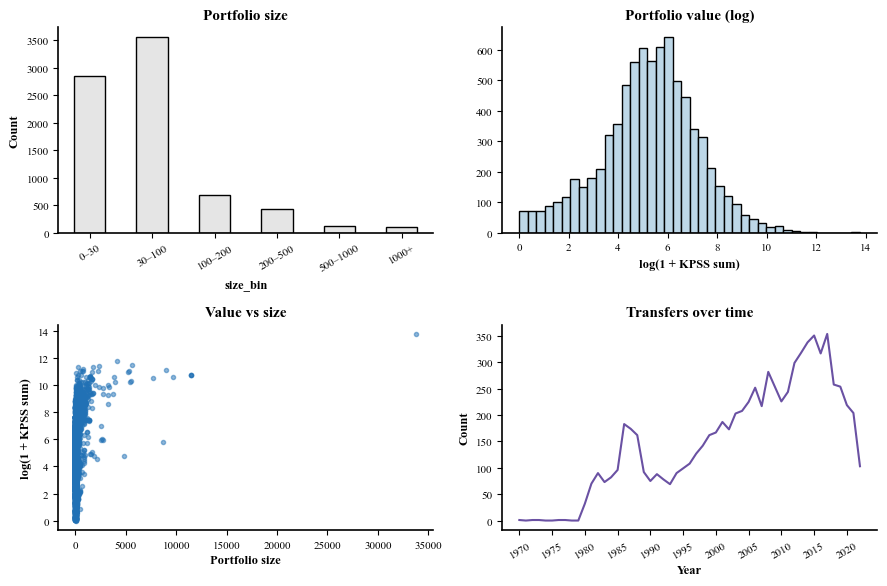

In [241]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({
    "figure.figsize": (9,6),
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 9,
    "axes.labelweight": "bold",
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

pc = portfolio_clusters.dropna(subset=["portfolio_kpss_sum"]).copy()

bins = [0, 30, 100, 200, 500, 1000, np.inf]
labels = ["0–30", "30–100", "100–200", "200–500", "500–1000", "1000+"]
pc["size_bin"] = pd.cut(pc["n_patents"], bins=bins, labels=labels, right=False)

fig, ax = plt.subplots(2, 2)

# (1) Portfolio size bins
pc["size_bin"].value_counts().loc[labels].plot(
    kind="bar", ax=ax[0,0],
    color="#E5E5E5", edgecolor="black"
)
ax[0,0].set_title("Portfolio size", fontweight="bold", fontsize=11)
ax[0,0].set_ylabel("Count")
ax[0,0].tick_params(axis="x", rotation=30)

# (2) Portfolio value distribution
ax[0,1].hist(
    np.log1p(pc["portfolio_kpss_sum"]),
    bins=40, color="#BDD7E7", edgecolor="black"
)
ax[0,1].set_title("Portfolio value (log)", fontweight="bold", fontsize=11)
ax[0,1].set_xlabel("log(1 + KPSS sum)")

# (3) Value vs size
ax[1,0].scatter(
    pc["n_patents"],
    np.log1p(pc["portfolio_kpss_sum"]),
    s=9, alpha=0.5, color="#2171B5"
)
ax[1,0].set_title("Value vs size", fontweight="bold", fontsize=11)
ax[1,0].set_xlabel("Portfolio size")
ax[1,0].set_ylabel("log(1 + KPSS sum)")

# (4) Transfers over time
yc = pc["transfer_start"].dt.year.value_counts().sort_index()
full_years = yc.reindex(range(yc.index.min(), yc.index.max()+1), fill_value=0)

ax[1,1].plot(full_years.index, full_years.values, color="#6A51A3")
ax[1,1].set_title("Transfers over time", fontweight="bold", fontsize=11)
ax[1,1].set_xlabel("Year")
ax[1,1].set_ylabel("Count")
ax[1,1].set_xticks(full_years.index[::5])
ax[1,1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.savefig("portfolio_clusters_eda.png", dpi=300, bbox_inches="tight")

plt.show()


In [244]:
# -----------------
# FULLER STATS TABLE
# -----------------
cols = ["n_patents", "portfolio_kpss_sum", "portfolio_cites"]

stats = (
    portfolio_clusters[cols]
    .describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
    .T
)

stats


# -----------------
# TOP 10 TRANSFERS BY PATENT COUNT
# -----------------
top10_size = (
    portfolio_clusters
    .nlargest(10, "n_patents")
    [[
        "seller_name",
        "buyer_name",
        "buyer_permno",
        "n_patents",
        "portfolio_kpss_sum",
        "portfolio_cites",
        "transfer_start",
        "transfer_end",
    ]]
)

top10_size


# -----------------
# TOP 10 TRANSFERS BY KPSS VALUE
# -----------------
top10_value = (
    portfolio_clusters
    .nlargest(10, "portfolio_kpss_sum")
    [[
        "seller_name",
        "buyer_name",
        "buyer_permno",
        "n_patents",
        "portfolio_kpss_sum",
        "portfolio_cites",
        "transfer_start",
        "transfer_end",
    ]]
)

top10_value


,seller_name,buyer_name,buyer_permno,n_patents,portfolio_kpss_sum,portfolio_cites,transfer_start,transfer_end
3980936,MICROSOFT CORPORATION,MICROSOFT TECHNOLOGY LICENSING LLC,10107.0,33778,958405.849032,694519.0,2014-10-14,2014-10-14
4381519,EMC CORPORATION,EMC IP HOLDING COMPANY LLC,10147.0,4139,132558.162357,112596.0,2016-09-06,2016-09-06
1819606,HEWLETTPACKARD COMPANY,HEWLETTPACKARD DEVELOPMENT COMPANY LP,27828.0,5581,97436.202166,150672.0,2003-01-31,2003-01-31
5314288,ETHICON LLC,CILAG GMBH INTERNATIONAL,22111.0,2395,93450.142797,1350556.0,2021-04-05,2021-04-05
1961019,ORACLE CORPORATION,ORACLE INTERNATIONAL CORPORATION,10104.0,230,83182.224252,14662.0,2003-10-28,2003-10-28
1572486,COMPAQ COMPUTER CORPORATION,COMPAQ INFORMATION TECHNOLOGIES GROUP LP,68347.0,1717,80772.610341,80138.0,2001-06-20,2001-06-20
5050664,INTEL CORPORATION,APPLE INC,14593.0,814,71631.746141,1111.0,2019-11-30,2019-11-30
4185765,HEWLETTPACKARD DEVELOPMENT COMPANY LP,HEWLETT PACKARD ENTERPRISE DEVELOPMENT LP,27828.0,8969,66912.222537,113344.0,2015-10-27,2015-10-27
3876658,VERIZON SERVICES CORP,VERIZON PATENT AND LICENSING INC,65875.0,486,64086.345768,43278.0,2014-04-09,2014-04-09
3388981,NORTEL NETWORKS LIMITED,ROCKSTAR BIDCO LP,58640.0,2212,63807.232599,98283.0,2011-07-29,2011-07-29


In [245]:
# ---------- STATS TABLE ----------
stats.to_latex(
    "portfolio_clusters_stats.tex",
    float_format="%.3f",
    index=True
)

# ---------- TOP 10 BY PATENT COUNT ----------
top10_size.to_latex(
    "top10_transfers_by_size.tex",
    index=False,
    float_format="%.3f"
)

# ---------- TOP 10 BY KPSS VALUE ----------
top10_value.to_latex(
    "top10_transfers_by_value.tex",
    index=False,
    float_format="%.3f"
)
